#  Cartpole  Off policy algorithm: Deep Q learning

Q-learning is an off policy reinforcement learning algorithm that seeks to find the best action to take given the current state. It’s considered off-policy because the q-learning function learns from actions that are outside the current policy, like taking random actions, and therefore a policy isn’t needed. More specifically, q-learning seeks to learn a policy that maximizes the total reward.  
Deep Q learning approximates the Q function with a deep neural network.

## Q learning algorithm: 

As en extension to the Q learning algorithm, I will use experience replay and a second network serving as a target network. Why?

FOR number of episodes:  
    
    0. Act on the environment and add sequences to experience replay memory.
    1. Sample from the experience replay a number of state/action/reward/next-state instance (is considered an episode).  
    2. Pass the state through the Q network to receive the action values.  
    3. Pass the next-state through the target Q network to receive the next state action values.  
    4. Update Q network weights using the Bellman Equation and gradient decent.  
    5. (Update target network weights based on a given frequency)

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
from gym import wrappers
from collections import deque
import random
from torch.autograd import Variable


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-2fn179dp because the default path (/home/mihalis/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [4]:
env = gym.make('CartPole-v0') # Create environment

In [5]:
s = env.reset()
a = env.action_space.sample()
print(s.shape)
print('sample state:', s)
print('sample action:', a )

(4,)
sample state: [-0.00882824 -0.01441716  0.00803367 -0.04113224]
sample action: 0


In [6]:
def show_replay():
    """
    Not-so-elegant way to display the MP4 file generated by the Monitor wrapper inside a notebook.
    The Monitor wrapper dumps the replay to a local file that we then display as a HTML video object.
    """
    import io
    import base64
    from IPython.display import HTML
    video = io.open('./gym-results/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''
        <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
    .format(encoded.decode('ascii')))

In [7]:
env = gym.make('CartPole-v0') # Create environment
env = wrappers.Monitor(env, "./gym-results", force=True) # Create wrapper to display environment
env.reset() # Reset environment

# Run environment
while True:
    env.render() # Render environment
    action = env.action_space.sample() # Get a random action
    _, _, done, _ = env.step(action) # Take a step
    if done: break # Break if environment is done

env.close() # Close environment
show_replay()

Taking random actions does not do a very good job at balancing the pole. Let us now apply the Policy Gradient method described above to solve this task!

Let's first define our network and helper functions.

In [8]:
class ReplayMemory(object):
    """Experience Replay Memory"""
    
    def __init__(self, capacity):
        #self.size = size
        self.memory = deque(maxlen=capacity)
    
    def add(self, *args):
        """Add experience to memory."""
        self.memory.append([*args])
    
    def sample(self, batch_size):
        """Sample batch of experiences from memory with replacement."""
        return random.sample(self.memory, batch_size)
    
    def count(self):
        return len(self.memory)

In [9]:
class DeepQN(nn.Module):
    """DeepQN network"""

    def __init__(self, n_inputs, n_hidden, n_actions, learning_rate):
        super(DeepQN, self).__init__()
        #loss
        self.criterion = torch.nn.MSELoss()
        # network
        self.hidden = nn.Linear(n_inputs, n_hidden)
        self.hidden2 = nn.Linear(n_hidden,n_hidden*2)
        self.out = nn.Linear(n_hidden*2, n_actions)
        # training
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = self.hidden(x)
        x = F.relu(x)
        x = self.hidden2(x)
        x = F.relu(x)
        x = self.out(x)
        return x

    def update(self, y_pred, y):
            """Update the weights of the network given a training sample. """
            loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
            loss.backward()
            self.optimizer.step()
    
    def update_params(self,new_params,taf):
        params = self.state_dict()
        for k in params.keys():
            params[k] = (1-tau) * params[k] + tau * new_params[k]
        self.load_state_dict(params)

To start with, our policy will be a rather simple neural network with one hidden layer. We can retrieve the shape of the state space (input) and action space (output) from the environment.

In [51]:
n_inputs = env.observation_space.shape[0]
n_outputs = env.action_space.n

print('state shape:', n_inputs)
print('action shape:', n_outputs)

state shape: 4
action shape: 2


Prefil the momeory to sample

In [73]:
replay_memory_capacity = 500
batch_size=16

prefil_memory=True
ss = np.zeros((batch_size,4),dtype=float)
replay_memory = ReplayMemory(replay_memory_capacity)
#fill replay_memory_queue
if prefil_memory:
    s = env.reset()
    while replay_memory.count()<replay_memory_capacity:
        action = env.action_space.sample() # Get a random action
        next_state, reward, done, _ = env.step(action) # Take a step
        replay_memory.add(s,action,reward,next_state,done)
        s = next_state if not done else env.reset()

In [78]:
n_hidden = 128

learning_rate = 0.001 

# setup policy network

q_table = DeepQN(n_inputs, n_hidden, n_outputs, learning_rate)
target = DeepQN(n_inputs, n_hidden, n_outputs, learning_rate)
target.load_state_dict(q_table.state_dict())

s = env.reset()
q_table(torch.from_numpy(np.atleast_2d(s)).float()).argmax().item()

0

In [79]:
def run_single_episode_for_memory(q_table,env,replay_memory):
    
    s = env.reset()
    done = False
    rewards = 0
    with torch.no_grad():
        while not done:
            if np.random.rand() < epsilon:
                a = env.action_space.sample()
            else:
                a = q_table(torch.from_numpy(np.atleast_2d(s)).float()).argmax().item()
            # perform action
            s1,r,done,_ = env.step(a)
            rewards+=r
            # add it to memory
            replay_memory.add(s,a,r,s1,done)
            s=s1
            
    return rewards

def decay_epsilon(epsilon,episode_reward,reward_threshold):
    if epsilon > 0 and episode_reward >= reward_threshold:    
        epsilon = epsilon - eps_d    
        reward_threshold = reward_threshold + r_increase
    return epsilon, reward_threshold

In [80]:
# training settings
gamma = 0.99 # reward discount factor (gamma), 1.0 = no discount
GOAL = 195
val_freq = 200 # validation frequency
tau = 1

# train policy network
epsilon = 0.3
eps_d = epsilon/GOAL
r_increase = 1
reward_threshold = 0

episode_counter = 0
training_rewards= []

print('start training')

while True:


    episode_rewards = run_single_episode_for_memory(q_table,env,replay_memory)

    # For a batch of action-states from memory
    if replay_memory.count() >= batch_size:
        # get the batch of state-reward-actions
        batch = np.array(replay_memory.sample(batch_size),dtype=object)
        ss,aa,rr,ss1,dd = np.array(list(batch[:,0]),dtype=float),batch[:,1],batch[:,2],np.array(list(batch[:,3]),dtype=float),batch[:,4]
        # do a forward pass
        q_table.optimizer.zero_grad()
        Q = q_table(torch.from_numpy(ss).float())
        #  do a pass from the target network and copy resulting policies
        with torch.no_grad():
            Q1 = target(torch.from_numpy(ss1).float())
        q_targets = Q.clone()
        # calculate updated policies
        for k in range(batch_size):
            q_targets[k,aa[k]] = rr[k] + gamma*Q1[k].max().item()*(not dd[k])
        # do backprop
        q_table.update(Q,q_targets)
        
        # update target parameters ( do i need to do that here?)
        target.update_params(q_table.state_dict(), tau)
    else:
        pass

    # Increment episode counter
    episode_counter+=1

    # Stop if running average reward is greater than 195
    if np.mean(training_rewards[-val_freq:]) >= GOAL: break
        
    # update the epsilon 
    epsilon, reward_threshold = decay_epsilon(epsilon,episode_rewards,reward_threshold) 
    #bookeeping
    training_rewards.append(episode_rewards)

    if episode_counter % val_freq == 0:
        # update target parameters ( do i need to do that here?)
        target.update_params(q_table.state_dict(), tau)
        print('%5d mean training reward: %5.2f' % (episode_counter, np.mean(training_rewards[-val_freq:])))
        
print("done")
   

start training
  200 mean training reward: 14.93
  400 mean training reward: 31.82
  600 mean training reward: 40.90
  800 mean training reward: 66.03
 1000 mean training reward: 94.69
 1200 mean training reward: 112.50
 1400 mean training reward: 158.79
 1600 mean training reward: 147.38
 1800 mean training reward: 165.28
 2000 mean training reward: 132.29
 2200 mean training reward: 171.43
 2400 mean training reward: 138.57
 2600 mean training reward: 163.94
 2800 mean training reward: 190.28
done


## Visualizing average Rewards and cartpole`s behaviour.

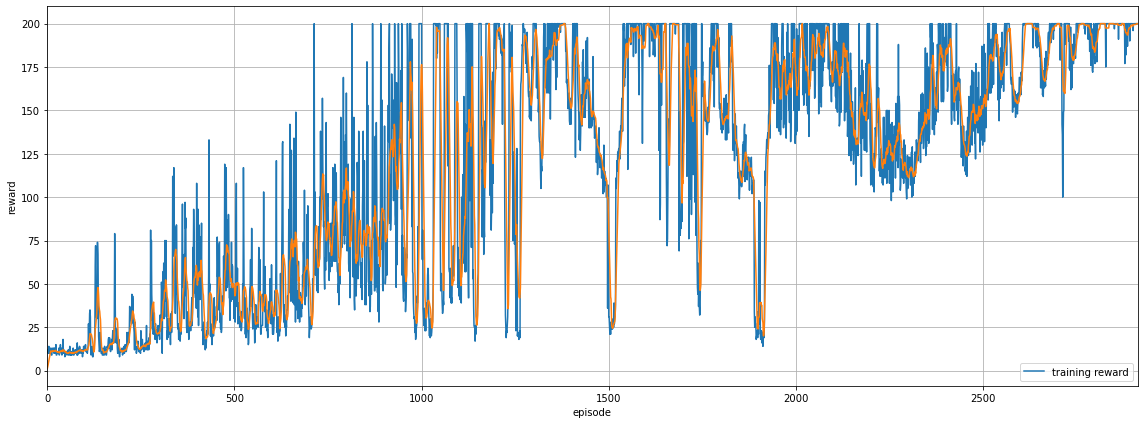

In [81]:
# plot results
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16,6))
plt.subplot(111)
plt.plot(range(1, len(training_rewards)+1), training_rewards, label='training reward')
plt.plot(moving_average(training_rewards))
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()
plt.tight_layout(); plt.show()

In [41]:
env = wrappers.Monitor(env, "./gym-results", force=True) # Create wrapper to display environment
s = env.reset()

for _ in range(500):
    env.render()
    a = q_table(torch.from_numpy(np.atleast_2d(s)).float()).argmax().item()
    s, r, done, _ = env.step(a)
    if done: break
    
env.close()
show_replay()